# 🤖 Heart Disease Prediction - Model Development

## 📌 Objective  
This notebook develops and evaluates **machine learning models** to predict heart disease.  
We will:
1. **Load & Prepare Data**
2. **Split Data into Train & Test Sets**
3. **Train Multiple Models & Compare Performance**
4. **Select Best Model (Logistic Regression)**
5. **Perform In-Depth Analysis on Logistic Regression**


## 📂 Load Processed Data

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance, plot_partial_dependence

# Load preprocessed dataset (from Feature Engineering step)
file_path = "Engineered_Data.csv"  # Update path if needed
df = pd.read_csv(file_path)

# Create a directory for saving figures
figures_dir = "Visuals"
os.makedirs(figures_dir, exist_ok=True)

# Separate features and target variable
X = df.drop(columns=["Heart Disease"])  # Features
y = df["Heart Disease"]  # Target

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Confirm data split
print(f"Train set size: {X_train.shape}, Test set size: {X_test.shape}")


Train set size: (216, 17), Test set size: (54, 17)


## 🤖 Train Multiple Machine Learning Models & Select Best One

In [3]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC-ROC": roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }

# Convert results to DataFrame for easy comparison
results_df = pd.DataFrame(results).T
print(results_df)

# Save best model (Logistic Regression) for interpretation
best_model = models["Logistic Regression"]
joblib.dump(best_model, "Best_Logistic_Regression_Model.pkl")


                     Accuracy  Precision    Recall  F1 Score   AUC-ROC
Logistic Regression  0.870370   0.814815  0.916667  0.862745  0.918056
Random Forest        0.796296   0.740741  0.833333  0.784314  0.896528
SVM                  0.833333   0.800000  0.833333  0.816327  0.901389
KNN                  0.833333   0.777778  0.875000  0.823529  0.879167


['Best_Logistic_Regression_Model.pkl']

## 🔥 Feature Importance for Logistic Regression

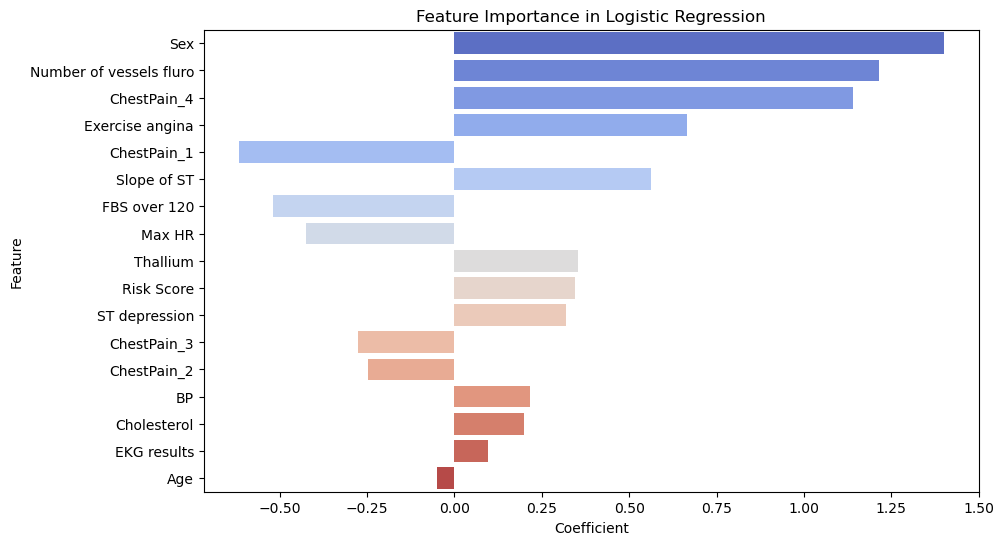

In [4]:
# Load the best model
best_model = joblib.load("Best_Logistic_Regression_Model.pkl")

# Get feature coefficients
coefficients = best_model.coef_[0]
feature_names = X.columns

# Convert to DataFrame for visualization
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
feature_importance_df["Absolute Coefficient"] = feature_importance_df["Coefficient"].abs()
feature_importance_df = feature_importance_df.sort_values(by="Absolute Coefficient", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=feature_importance_df, palette="coolwarm")
plt.title("Feature Importance in Logistic Regression")
plt.savefig(os.path.join(figures_dir, "Feature_Importance_Logistic_Regression.png"))  # Fixed
plt.show()

## 🧠 SHAP Interpretation (Explaining Logistic Regression Decisions)

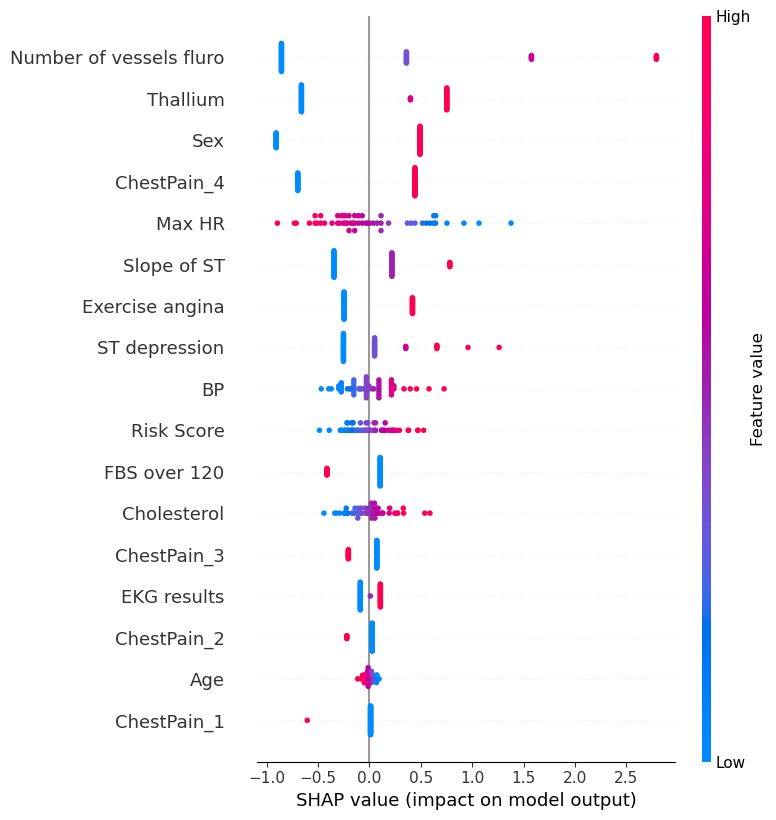

<Figure size 640x480 with 0 Axes>

In [5]:
# Compute SHAP values for Logistic Regression
explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)
plt.savefig(os.path.join(figures_dir, "SHAP_Summary_Logistic_Regression.png"))  # Fixed

## 📊 Confusion Matrix & Classification Report

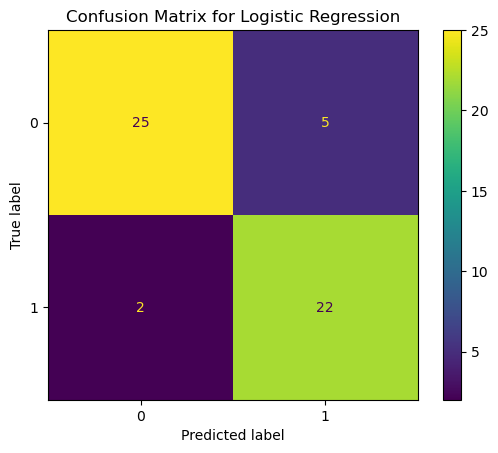

              precision    recall  f1-score   support

           0       0.93      0.83      0.88        30
           1       0.81      0.92      0.86        24

    accuracy                           0.87        54
   macro avg       0.87      0.88      0.87        54
weighted avg       0.88      0.87      0.87        54



In [6]:
# Predictions
y_pred = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix for Logistic Regression")
plt.savefig(os.path.join(figures_dir, "Confusion_Matrix_Logistic_Regression.png"))  # Fixed
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))


## 📈 AUC-ROC & Precision-Recall Curves for Logistic Regression

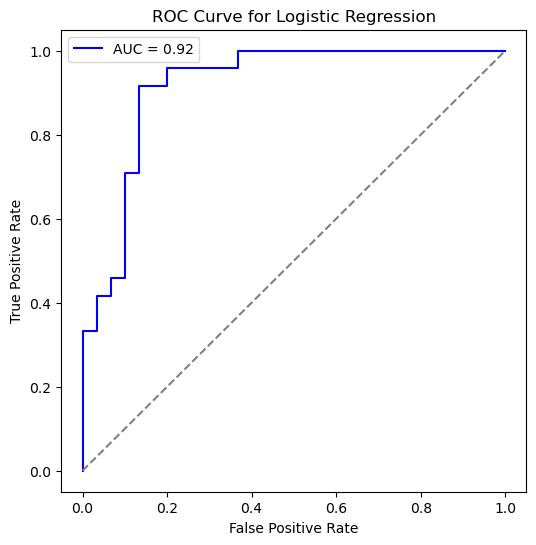

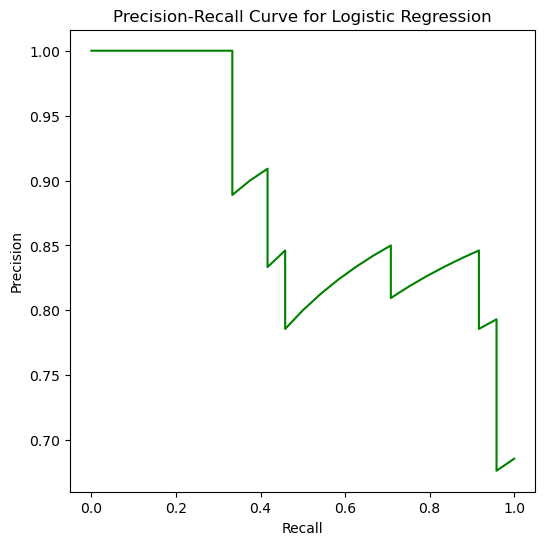

In [7]:
# Get probabilities for ROC curve
y_prob = best_model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression")
plt.legend()
plt.savefig(os.path.join(figures_dir, "ROC_Curve_Logistic_Regression.png"))  # Fixed
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Logistic Regression")
plt.savefig(os.path.join(figures_dir, "Precision_Recall_Curve_Logistic_Regression.png"))  # Fixed
plt.show()
